In [18]:
import gzip
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import Functions
from sklearn.utils.class_weight import compute_class_weight 
import pickle


In [43]:
with gzip.open('cleaned_data.zip','rb') as file:
    feature_data = pd.read_csv(file,index_col=[0,1])

with gzip.open('new_label_data.zip','rb') as file:
    new_label_data = pd.read_csv(file,index_col=[0,1])

data = pd.concat([feature_data,new_label_data],join='inner',ignore_index=False,axis=1)

X_train, X_test, Y_train, Y_test = Functions.splitdata(data,0.1)

In [44]:
classes = list(range(7))
print(classes)
weight = compute_class_weight(class_weight = 'balanced', classes = classes, y = Y_train)
weight = dict(zip(classes,weight))
print(weight)
X_train = tf.reshape(X_train, (-1,3,50))
X_test = tf.reshape(X_test, (-1,3,50))
Y_train = tf.reshape(Y_train, (-1,3))
Y_test = tf.reshape(Y_test, (-1,3))
print(X_train.shape)
print(Y_train.shape)

[0, 1, 2, 3, 4, 5, 6]
{0: 0.5461265517205498, 1: 0.5455860920474603, 2: 1.9688491750883432, 3: 3.706630130794655, 4: 1.119504797170757, 5: 4.19714029812552, 6: 0.700857303100713}
(87474, 3, 50)
(87474, 3)


In [47]:
input_dim = 50
units = 256
batch_size = int(len(X_train)//10000)
output_size = 7  # labels are from 0 to 6

# Build the RNN model
def build_model():
    gru_layer = keras.layers.GRU(units, input_shape=(None,input_dim))
    model = keras.models.Sequential(
        [
            gru_layer,
            keras.layers.Dropout(0.1),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(output_size, activation='softmax'),
        ]
    )
    return model

In [ ]:
model = build_model()

#model.summary()
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer="Adamax",
    metrics=["accuracy"]
)
GRU_model = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=batch_size, epochs=50, verbose=1,class_weight=weight)

In [23]:
model.save('./GRU_model')
with open('./GRU_model/log.txt', 'wb') as file_txt:
    pickle.dump(GRU_model.history, file_txt)

INFO:tensorflow:Assets written to: ./GRU_model\assets


INFO:tensorflow:Assets written to: ./GRU_model\assets


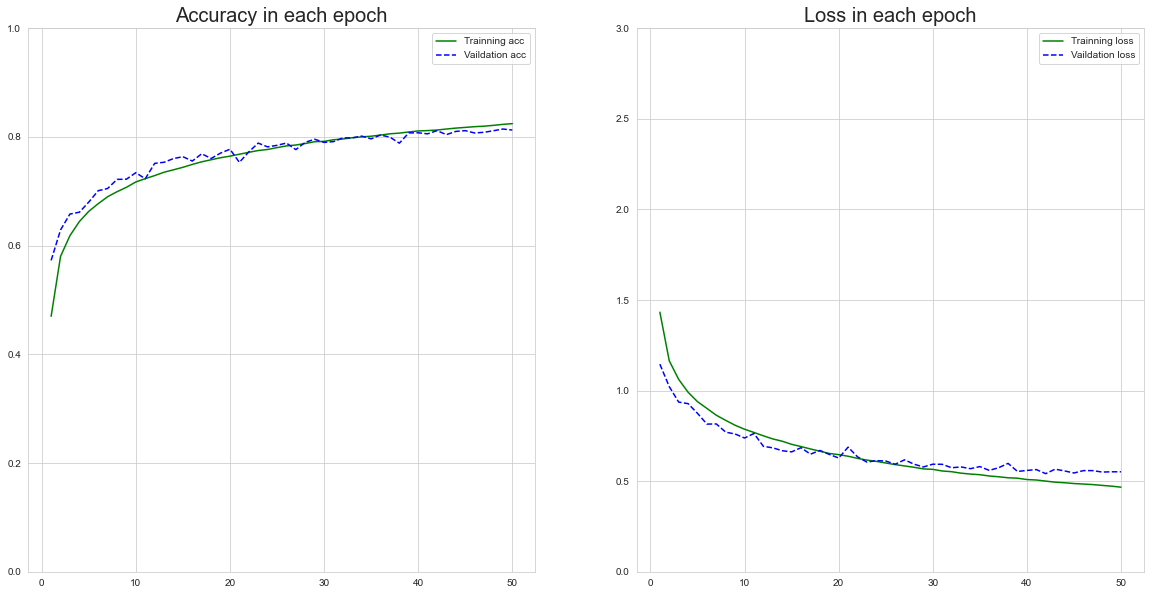

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns  
sns.set_style("whitegrid") 

with open('./GRU_model/log.txt','rb') as file_txt:
    history=pickle.load(file_txt)

acc = history['accuracy']     #获取训练集准确性数据
val_acc = history['val_accuracy']    #获取验证集准确性数据
loss = history['loss']          #获取训练集错误值数据
val_loss = history['val_loss']  #获取验证集错误值数据

epochs = range(1,len(acc)+1)
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.plot(epochs,acc,'g',label='Trainning acc')     #以epochs为横坐标，以训练集准确性为纵坐标
ax1.plot(epochs,val_acc,'b--',label='Vaildation acc') #以epochs为横坐标，以验证集准确性为纵坐标
ax1.legend()   #绘制图例，即标明图中的线段代表何种含义
ax1.set_title('Accuracy in each epoch',fontsize=20)
plt.ylim(0,1)
ax2 = fig.add_subplot(122)
ax2.plot(epochs,loss,'g',label='Trainning loss')
ax2.plot(epochs,val_loss,'b--',label='Vaildation loss')
ax2.legend()  ##绘制图例，即标明图中的线段代表何种含义
ax2.set_title('Loss in each epoch',fontsize=20)
plt.ylim(0,3)
plt.show()

911/911 [==============================] - 4s 4ms/step


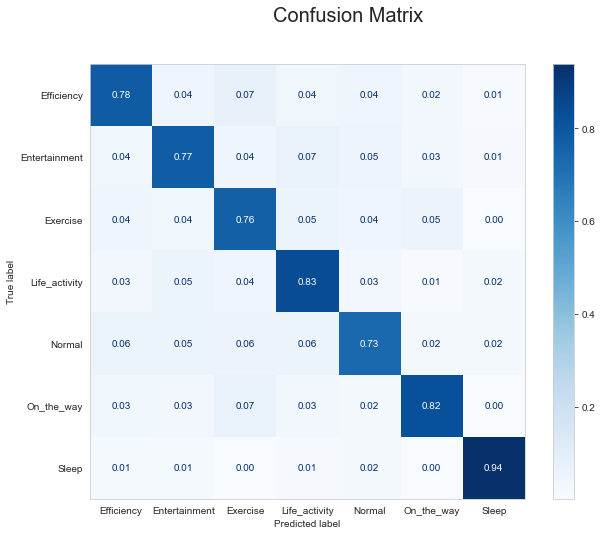

In [40]:
from sklearn import metrics

load_model = keras.models.load_model('./GRU_model')

predictions = load_model.predict(X_test)
y_test_pred = np.argmax(predictions, axis=1)

new_label_dict = {0:'Sleep', 1:'Efficiency', 2:'Exercise', 3:'Life_activity', 4:'Entertainment', 5:'On_the_way', 6:'Normal'}
y_test_pred = [new_label_dict.get(i) for i in y_test_pred]
y_test_true = [new_label_dict.get(i) for i in Y_test]


confusion = metrics.ConfusionMatrixDisplay.from_predictions(y_test_true,y_test_pred,cmap='Blues',normalize='true',values_format='.2f')
confusion.figure_.suptitle("Confusion Matrix",fontsize=20)
confusion.figure_.set_size_inches(10,8)
plt.grid(visible=None)
plt.show()